## Regularization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge as SklearnRidge
from sklearn.linear_model import Lasso as SklearnLasso
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118


#### Why Regularization?
- Prevents Overfitting: Especially when the number of features is large or features are highly correlated, standard linear regression models can overfit the training data, leading to poor generalization on unseen data. Overfitting often manifests as very large parameter weights.
- Handles Multicollinearity: When features are highly correlated, the variance of the coefficient estimates can be large. Regularization helps to stabilize these estimates.
- Feature Selection (Lasso): L1 regularization can shrink some feature weights exactly to zero, effectively performing feature selection.

How it works:</br></br>
Regularization adds a penalty term to the cost function that penalizes large weights.</br>
Cost_Regularized = Original_Cost (e.g., MSE) + Regularization_Term</br>

In [2]:
# Generate synthetic Data with more features

N_SAMPLES = 100
N_FEATURES = 10     # Total Features
N_INFORMATIVE_FEATURES = 5      # Number of features actually used to generate y
NOISE_LEVEL = 15.0
EFFECTIVE_RANK = N_INFORMATIVE_FEATURES     # For creating correlated features if desired

In [3]:
X_numpy, y_numpy, true_coefficients_numpy = make_regression(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    n_informative=N_INFORMATIVE_FEATURES,
    noise=NOISE_LEVEL,
    coef=True, # Returns the true coefficients used to generate the data
    random_state=42,
    # effective_rank=EFFECTIVE_RANK # Can be used to introduce collinearity
)

In [7]:
X_numpy[:5], y_numpy[:5], y_numpy.shape

(array([[-0.92693047, -1.43014138,  1.6324113 , -3.24126734, -1.24778318,
         -1.02438764,  0.13074058, -0.05952536, -0.25256815, -0.44004449],
        [ 0.20292302,  0.33445679,  0.28586539,  1.5475052 , -0.38770156,
          1.79587767,  2.01020454, -1.51574411, -0.61278869,  0.65854427],
        [-0.24123606,  0.45675322,  0.34272535, -1.25153942,  1.11729583,
          1.4437646 ,  0.44770856,  0.3520554 , -0.08215118,  0.56976728],
        [ 0.28977486, -1.00808631, -2.03812454,  0.8711247 , -0.40807537,
         -0.32602353, -0.35151348,  2.0754008 ,  1.20121392, -1.87079192],
        [-0.00797264, -0.19033868, -1.03724615,  0.07736831,  0.53891004,
         -0.8612842 , -1.38279973,  1.47994414,  1.52312408, -0.87561825]]),
 array([-279.2335471 ,  208.12562978,   65.79460221,   68.37185465,
         -36.52713767]),
 (100,))

In [8]:
y_numpy = y_numpy.reshape(-1,1)

In [9]:
y_numpy.shape

(100, 1)

In [11]:
print("True coefficients used by make_regression:")
print(true_coefficients_numpy) # "ideal" weights to recover for the informative features

True coefficients used by make_regression:
[16.74825823  0.          0.         63.64302495  0.         70.64757265
  0.         10.45678403  3.15861448  0.        ]


In [12]:
# Standardize features (important for regularization, as it's sensitive to feature scales)
scaler = StandardScaler()
X_scaled_numpy = scaler.fit_transform(X_numpy)

In [13]:
X_scaled_numpy.shape

(100, 10)

In [14]:
X = torch.from_numpy(X_scaled_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))

In [17]:
X[:5]

tensor([[-1.0458, -1.6318,  1.7689, -3.1264, -1.2503, -1.1205,  0.0712, -0.0596,
         -0.3201, -0.5138],
        [ 0.2240,  0.3295,  0.3512,  1.5629, -0.3654,  1.6678,  1.9183, -1.4570,
         -0.6673,  0.6840],
        [-0.2752,  0.4654,  0.4111, -1.1780,  1.1831,  1.3197,  0.3827,  0.3354,
         -0.1558,  0.5872],
        [ 0.3216, -1.1627, -2.0954,  0.9005, -0.3864, -0.4301, -0.4028,  1.9891,
          1.0812, -2.0736],
        [-0.0130, -0.2538, -1.0417,  0.1233,  0.5880, -0.9593, -1.4163,  1.4177,
          1.3915, -0.9886]])

In [18]:
X.dtype

torch.float32

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, y_train.shape

(torch.Size([80, 10]), torch.Size([80, 1]))

### Standard Linear Regression (No Regularization)

In [112]:
def train_linear_regression(x, y, lr, epochs, reg_type=None, alpha=0.0):
    n_samples, n_features = x.shape

    weights = torch.randn(n_features, 1, requires_grad=True, dtype=torch.float32)
    bias = torch.randn(1, requires_grad=True, dtype=torch.float32)

    loss_history = []

    for epoch in range(epochs):
        # Forward pass: y_pred = X @ weights + bias
        y_predicted = x @ weights + bias 
        # Compute MSE loss
        mse_loss = torch.mean((y_predicted -y)**2)
        # Add regularization term to the loss (if any)
        total_loss = mse_loss
        if reg_type == 'l2': #Ridge
            l2_penalty = alpha * torch.sum(weights**2) #L2 norm squared of weights
            total_loss += l2_penalty
        elif reg_type == 'l1': #Lasso
            l1_penalty = alpha * torch.sum(torch.abs(weights)) #L1 norm of weights
            total_loss += l1_penalty

        loss_history.append(total_loss.item())

        # Backward pass: compute gradients
        if weights.grad is not None: weights.grad.zero_()
        if bias.grad is not None: bias.grad.zero_()
        total_loss.backward() #Gradients are computed for the total loss

        # Update parameters
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad

    return weights.detach(), bias.detach(), loss_history
            

In [113]:
lr = 0.01
epochs = 1000

In [114]:
weights_lm, bias_lm, loss_hist_lm = train_linear_regression(
    X_train, y_train, lr, epochs
    )

In [115]:
print(f"Standard LR - Bias: {bias_lm.item():.4f}")

Standard LR - Bias: 6.6750


In [116]:
print("Standard LR - Weights:")
for i, w in enumerate(weights_lm):
    print(f"  Feature {i}: {w.item():.4f}")

Standard LR - Weights:
  Feature 0: 15.1455
  Feature 1: 0.4345
  Feature 2: 1.0349
  Feature 3: 63.5683
  Feature 4: 2.8908
  Feature 5: 70.8092
  Feature 6: -1.4714
  Feature 7: 9.3556
  Feature 8: 3.7752
  Feature 9: -1.1873


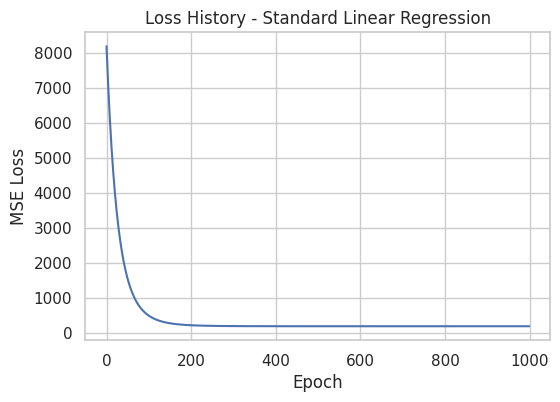

In [117]:
plt.figure(figsize=(6,4))
plt.plot(loss_hist_lm)
plt.title("Loss History - Standard Linear Regression")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); 
plt.show()

### Ridge Regression (L2 Regularization)
Cost_Ridge = MSE + alpha * sum(weights^2) </br>
Gradient update for weights will have an additional term: - learning_rate * 2 * alpha * weights     </br>
(This extra term comes from the derivative of alpha * sum(weights^2))

In [118]:
ALPHA_RIDGE = 1.0   # REgularization strength

In [119]:
weights_ridge, bias_ridge, loss_hist_ridge = train_linear_regression(
    X_train, y_train, lr, epochs, reg_type='l2', alpha=ALPHA_RIDGE
)

In [120]:
print(f"Ridge Regression (alpha={ALPHA_RIDGE}) - Bias: {bias_ridge.item():.4f}")

Ridge Regression (alpha=1.0) - Bias: 9.9339


In [121]:
print(f"Ridge Regression - Weights (alpha={ALPHA_RIDGE}):")
for i, w in enumerate(weights_ridge):
    print(f"  Feature {i}: {w.item():.4f}")

Ridge Regression - Weights (alpha=1.0):
  Feature 0: 8.3516
  Feature 1: -3.9305
  Feature 2: 2.7854
  Feature 3: 28.3746
  Feature 4: -0.6548
  Feature 5: 31.5108
  Feature 6: 5.0423
  Feature 7: 5.2895
  Feature 8: 2.4834
  Feature 9: 1.5839


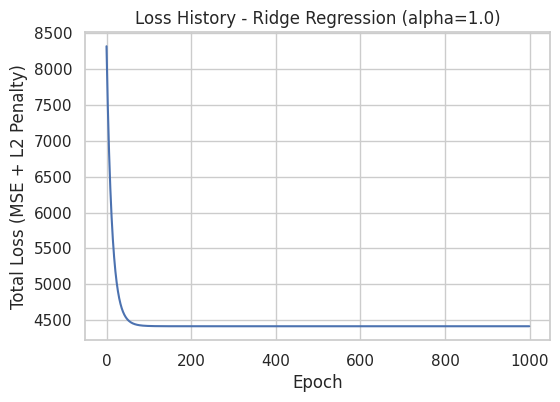

In [122]:
plt.figure(figsize=(6,4))
plt.plot(loss_hist_ridge)
plt.title(f"Loss History - Ridge Regression (alpha={ALPHA_RIDGE})")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (MSE + L2 Penalty)"); plt.show()

### Lasso Regression (L1 Regularization)
Cost_Lasso = MSE + alpha * sum(|weights|) </br>
Gradient of sum(|weights|) w.r.t. w_j is alpha * sign(w_j) for w_j != 0.

In [123]:
# More advanced algorithms like Coordinate Descent or Proximal Gradient methods (e.g., ISTA)
# are typically used for Lasso to robustly handle the non-differentiability at zero.

In [124]:
ALPHA_LASSO = 0.1   # Regularization strength for Lasso (often smaller than Ridge alpha)

In [125]:
weights_lasso, bias_lasso, loss_hist_lasso = train_linear_regression(
    X_train, y_train, lr, epochs, reg_type='l1', alpha=ALPHA_LASSO
    )

In [126]:
weights_lasso[:5]

tensor([[15.0939],
        [ 0.3648],
        [ 0.9795],
        [63.4878],
        [ 2.8271]])

In [127]:
print(f"Lasso Regression (alpha={ALPHA_LASSO}) - Bias: {bias_lasso.item():.4f}")

Lasso Regression (alpha=0.1) - Bias: 6.7057


In [128]:
print(f"Lasso Regression - Weights (alpha={ALPHA_LASSO}):")
for i, w in enumerate(weights_lasso):
    print(f"  Feature {i}: {w.item():.4f}") # Observe if some are close to zero

Lasso Regression - Weights (alpha=0.1):
  Feature 0: 15.0939
  Feature 1: 0.3648
  Feature 2: 0.9795
  Feature 3: 63.4878
  Feature 4: 2.8271
  Feature 5: 70.7219
  Feature 6: -1.3843
  Feature 7: 9.3174
  Feature 8: 3.7075
  Feature 9: -1.0972


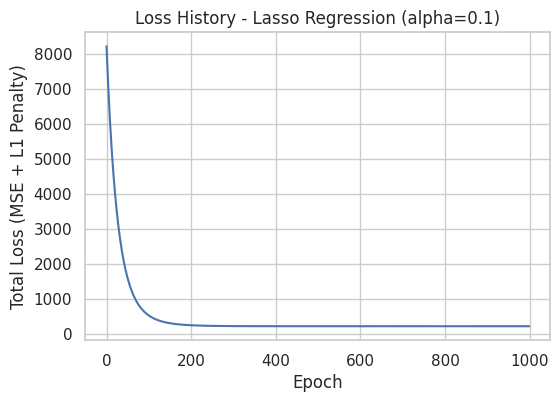

In [129]:
plt.figure(figsize=(6,4))
plt.plot(loss_hist_lasso)
plt.title(f"Loss History - Lasso Regression (alpha={ALPHA_LASSO})")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (MSE + L1 Penalty)"); plt.show()

### Comparing Learned Weights

In [130]:
# For better comparison, let's also train scikit-learn models
sklearn_ridge_model = SklearnRidge(alpha=ALPHA_RIDGE, fit_intercept=True)
sklearn_ridge_model.fit(X_train.numpy(), y_train.numpy())
weights_sklearn_ridge = sklearn_ridge_model.coef_.flatten() # sklearn weights are 1D array
bias_sklearn_ridge = sklearn_ridge_model.intercept_[0]

In [131]:
sklearn_lasso_model = SklearnLasso(alpha=ALPHA_LASSO, fit_intercept=True, max_iter=2000) # Increased max_iter
sklearn_lasso_model.fit(X_train.numpy(), y_train.numpy())
weights_sklearn_lasso = sklearn_lasso_model.coef_.flatten()
bias_sklearn_lasso = sklearn_lasso_model.intercept_[0]

In [132]:
feature_indices = np.arange(N_FEATURES)
bar_width = 0.15

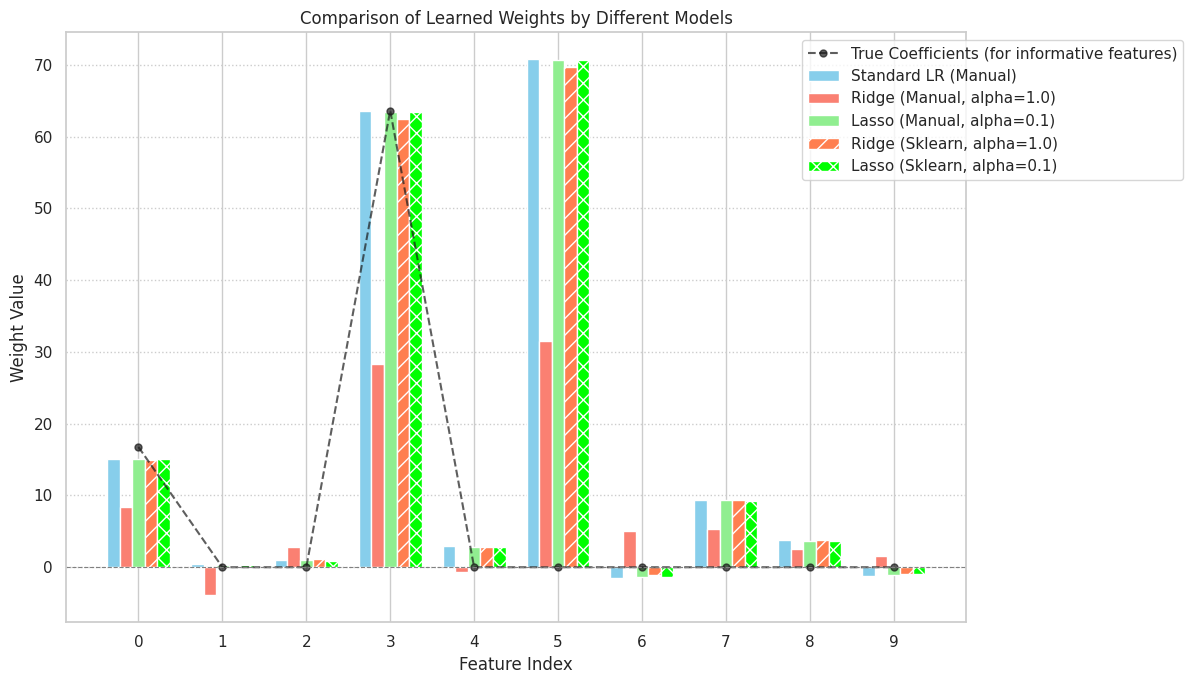

In [133]:
plt.figure(figsize=(15, 7))

plt.bar(feature_indices - 2*bar_width, weights_lm.numpy().flatten(), width=bar_width, label='Standard LR (Manual)', color='skyblue')
plt.bar(feature_indices - bar_width, weights_ridge.numpy().flatten(), width=bar_width, label=f'Ridge (Manual, alpha={ALPHA_RIDGE})', color='salmon')
plt.bar(feature_indices, weights_lasso.numpy().flatten(), width=bar_width, label=f'Lasso (Manual, alpha={ALPHA_LASSO})', color='lightgreen')
plt.bar(feature_indices + bar_width, weights_sklearn_ridge, width=bar_width, label=f'Ridge (Sklearn, alpha={ALPHA_RIDGE})', color='coral', hatch='//')
plt.bar(feature_indices + 2*bar_width, weights_sklearn_lasso, width=bar_width, label=f'Lasso (Sklearn, alpha={ALPHA_LASSO})', color='lime', hatch='xx')


# Plot true coefficients if available and meaningful (here they are for informative features)
# Remember only the first N_INFORMATIVE_FEATURES have non-zero true coefficients
true_coef_padded = np.zeros(N_FEATURES)
true_coef_padded[:N_INFORMATIVE_FEATURES] = true_coefficients_numpy[:N_INFORMATIVE_FEATURES] # Assuming make_regression puts informative first
plt.plot(feature_indices, true_coef_padded, 'ko--', label='True Coefficients (for informative features)', markersize=5, alpha=0.7)


plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.title("Comparison of Learned Weights by Different Models")
plt.xticks(feature_indices)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1)) # Adjust legend position
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()


- Ridge Regression shrinks weights towards zero but rarely makes them exactly zero.
- Lasso Regression can shrink weights exactly to zero, performing feature selection
- (Our manual Lasso with GD might not make them perfectly zero, but sklearn's Coordinate Descent does).
- The effect of regularization depends on the alpha value (strength).

### Evaluation

In [134]:
def evaluate_model(weights, bias, X_test_data, y_test_data, model_name="Model"):
    with torch.no_grad():
        y_pred = X_test_data @ weights + bias
    mse = mean_squared_error(y_test_data.numpy(), y_pred.numpy())
    r2 = r2_score(y_test_data.numpy(), y_pred.numpy())
    print(f"\n{model_name} Evaluation:")
    print(f"  MSE on Test Set: {mse:.4f}")
    print(f"  RMSE on Test Set: {np.sqrt(mse):.4f}")
    print(f"  R-squared on Test Set: {r2:.4f}")
    return mse, r2

In [135]:
evaluate_model(weights_lm, bias_lm, X_test, y_test, "Standard LR (Manual)")
evaluate_model(weights_ridge, bias_ridge, X_test, y_test, f"Ridge (Manual, alpha={ALPHA_RIDGE})")
evaluate_model(weights_lasso, bias_lasso, X_test, y_test, f"Lasso (Manual, alpha={ALPHA_LASSO})")


Standard LR (Manual) Evaluation:
  MSE on Test Set: 284.4530
  RMSE on Test Set: 16.8657
  R-squared on Test Set: 0.9833

Ridge (Manual, alpha=1.0) Evaluation:
  MSE on Test Set: 5981.3608
  RMSE on Test Set: 77.3393
  R-squared on Test Set: 0.6483

Lasso (Manual, alpha=0.1) Evaluation:
  MSE on Test Set: 285.8088
  RMSE on Test Set: 16.9059
  R-squared on Test Set: 0.9832


(285.8088, 0.9831958721440782)

In [136]:
# Evaluate Sklearn models
y_pred_sklearn_ridge = sklearn_ridge_model.predict(X_test.numpy())
mse_sklearn_ridge = mean_squared_error(y_test.numpy(), y_pred_sklearn_ridge)
r2_sklearn_ridge = r2_score(y_test.numpy(), y_pred_sklearn_ridge)
print(f"\nSklearn Ridge (alpha={ALPHA_RIDGE}) Evaluation:")
print(f"  MSE on Test Set: {mse_sklearn_ridge:.4f}, R2: {r2_sklearn_ridge:.4f}")


Sklearn Ridge (alpha=1.0) Evaluation:
  MSE on Test Set: 305.2239, R2: 0.9821


In [137]:
y_pred_sklearn_lasso = sklearn_lasso_model.predict(X_test.numpy())
mse_sklearn_lasso = mean_squared_error(y_test.numpy(), y_pred_sklearn_lasso)
r2_sklearn_lasso = r2_score(y_test.numpy(), y_pred_sklearn_lasso)
print(f"\nSklearn Lasso (alpha={ALPHA_LASSO}) Evaluation:")
print(f"  MSE on Test Set: {mse_sklearn_lasso:.4f}, R2: {r2_sklearn_lasso:.4f}")


Sklearn Lasso (alpha=0.1) Evaluation:
  MSE on Test Set: 287.2890, R2: 0.9831
